# overview of mvp data

In [1]:
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr

import gsw

# cognac data and tools
import cognac.insitu as iu

In [2]:
# select campaign

#campaign = 'microco_leg2.yaml'
#campaign = 'lopstech19_leg1.yaml'
campaign = 'cognac20.yaml'

cp = iu.events.campaign(campaign)

In [3]:
gps = cp.load('gps')
iridium = cp.load('iridium')
ship = cp.load('ship')
#emission = cp.load('log')
iridium = cp.load('iridium')
# ! tmp: waiting for cleaning up of gps data
gps['recepteur1'] = {d: g.resample('1T', interpolate=True) for d, g in iridium['recepteur1'].items()}

---

# load data

In [71]:
mvp_files = glob(cp.path+'mvp/nc/*L2*.nc')
ds = xr.load_dataset(mvp_files[0])
ds = ds.assign_coords(z=-ds.DEPTH,
                      range=iu.utils.get_distance(ds['LON'].isel(TIME=0), 
                                              ds['LAT'].isel(TIME=0),
                                              ds['LON'], 
                                              ds['LAT'],
                                             )/1e3, # km
                     )
print(ds.TIME[0].values)
print(ds.LAT[0].values)
print(ds.LAT[-1].values)

2020-11-24T18:12:45.000020032
7.086016999999999
7.189617


In [43]:
ds

<xarray.Dataset>
Dimensions:         (DEPTH: 414, TIME: 12)
Coordinates:
  * DEPTH           (DEPTH) float64 0.0 1.0 2.0 3.0 ... 410.0 411.0 412.0 413.0
  * TIME            (TIME) datetime64[ns] 2020-11-24T18:12:45.000020032 ... 2...
    z               (DEPTH) float64 -0.0 -1.0 -2.0 -3.0 ... -411.0 -412.0 -413.0
    range           (TIME) float64 0.0 1.092 2.134 3.2 ... 9.662 10.74 11.83
Data variables:
    STATION         (TIME) float64 1.0 2.0 3.0 4.0 5.0 ... 9.0 10.0 11.0 12.0
    LAT             (TIME) float64 7.086 7.096 7.105 7.114 ... 7.171 7.18 7.19
    LON             (TIME) float64 43.3 43.3 43.3 43.3 ... 43.28 43.28 43.28
    PRES            (DEPTH) float64 0.0 1.0 2.0 3.0 ... 410.0 411.0 412.0 413.0
    TEMP            (DEPTH, TIME) float64 nan nan nan nan ... nan nan nan nan
    COND            (DEPTH, TIME) float64 nan nan nan nan ... nan nan nan nan
    SAL             (DEPTH, TIME) float64 nan nan nan nan ... nan nan nan nan
    POTEMP          (DEPTH, TIME) float64 nan nan nan nan ... nan nan nan nan
    SIGMA_THETA     (DEPTH, TIME) float64 nan nan nan nan ... nan nan nan nan
    QC_STATION      (TIME) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    QC_TIME         (TIME) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    QC_LAT          (TIME) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    QC_LON          (TIME) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    QC_PRES         (DEPTH) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    QC_DEPTH        (DEPTH) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    QC_TEMP         (DEPTH, TIME) float64 9.0 9.0 9.0 9.0 ... 9.0 9.0 9.0 9.0
    QC_COND         (DEPTH, TIME) float64 9.0 9.0 9.0 9.0 ... 9.0 9.0 9.0 9.0
    QC_SAL          (DEPTH, TIME) float64 9.0 9.0 9.0 9.0 ... 9.0 9.0 9.0 9.0
    QC_POTEMP       (DEPTH, TIME) float64 9.0 9.0 9.0 9.0 ... 9.0 9.0 9.0 9.0
    QC_SIGMA_THETA  (DEPTH, TIME) float64 9.0 9.0 9.0 9.0 ... 9.0 9.0 9.0 9.0
Attributes:
    Principal_Investigator:   Aurelien PONTE
    Institution:              LOPS IFREMER https://www.umr-lops.fr
    Cruise_Name_Serie:        
    Cruise_Name:              cognac_2020
    geospatial_lat_min:       7.086017
    geospatial_lat_max:       7.189617
    geospatial_lon_min:       43.278933
    geospatial_lon_max:       43.303017
    geospatial_vertical_min:  1.014310484412849
    geospatial_vertical_max:  412.8187950976753
    time_coverage_start:      2020-11-24T18:12:45.000000000
    time_coverage_end:        2020-11-24T19:35:55.000000000

In [44]:
# add gsw core variables and sound speed

lon0 = ds['LON'].mean().values
lat0 = ds['LON'].mean().values
ds['SA'] = (('DEPTH', 'TIME'), 
            gsw.SA_from_SP(ds.SAL, (ds.PRES+ds.QC_TEMP*0.), lon0, lat0)
           )
ds['CT'] = (('DEPTH', 'TIME'), 
            gsw.CT_from_t(ds.SA, ds.TEMP, (ds.PRES+ds.QC_TEMP*0.))
           )
ds['sound_speed'] = (('DEPTH', 'TIME'), 
                     gsw.sound_speed(ds.SA, ds.CT, (ds.PRES+ds.QC_TEMP*0.))
                    )

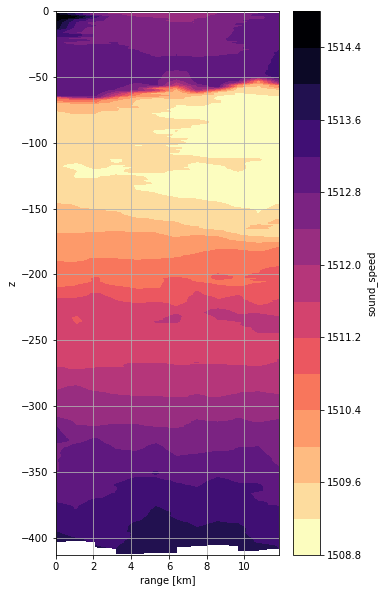

In [66]:
fig, ax = plt.subplots(1,1, figsize=(5,10))
ds.sound_speed.plot.contourf(x='range', y='z', levels=20, ax=ax, cmap='magma_r')
ax.set_xlabel('range [km]')
ax.grid()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,10))
ds.sound_speed.plot.contourf(x='range', y='z', levels=20, ax=ax, cmap='magma_r')
ax.set_xlabel('range [km]')
ax.grid()

In [60]:
plt.cm.Blues.